<a href="https://colab.research.google.com/github/juan1t0/multimodalDLforER/blob/master/Demo_n_other_evals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo: Inference and Evaluation of runtime

In [ ]:
mmer_repo = 'https://github.com/juan1t0/multimodalDLforER.git'
!git clone $mmer_repo

Cloning into 'multimodalDLforER'...
remote: Enumerating objects: 308, done.
remote: Counting objects: 100% (308/308), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 308 (delta 190), reused 199 (delta 91), pack-reused 0
Receiving objects: 100% (308/308), 1.20 MiB | 10.08 MiB/s, done.
Resolving deltas: 100% (190/190), done.


## Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip drive/MyDrive/Tesis-p/pp-dataset/Emotic_MultiDB.zip

In [ ]:
from multimodalDLforER.models.fusion_model import MergeClass

from multimodalDLforER.utils.dataset import Emotic_MultiDB, Rescale, RandomCrop, ToTensor
# from torchvision import transforms, utils

from multimodalDLforER.utils.dataset import my_collate as collate
from multimodalDLforER.utils.traineval import train_step, eval

from multimodalDLforER.models.context_net import resnet18 #, resnet50
from multimodalDLforER.models.face_net import ShortVGG as VGG
from multimodalDLforER.models.skeleton_net import Model as DGCNN

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np

In [ ]:
original_cats = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion',
                 'Confidence', 'Disapproval', 'Disconnection', 'Disquietment',
                 'Doubt/Confusion', 'Embarrassment', 'Engagement', 'Esteem',
                 'Excitement', 'Fatigue', 'Fear', 'Happiness', 'Pain', 'Peace',
                 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise',
                 'Sympathy', 'Yearning']

modal_dirs = ['context','face','person','posture-bones','posture-joints']

newlabeles = {'len':8,
              'cat':{'joy':['Excitement', 'Happiness', 'Peace', 'Affection', 'Pleasure',],
                     'trust':['Confidence', 'Esteem', 'Sympathy',],
                     'fear':['Disquietment','Embarrassment','Fear',],
                     'surprice':['Doubt/Confusion','Surprise',],
                     'sadness':['Pain', 'Sadness', 'Sensitivity', 'Suffering',],
                     'disgust':['Aversion','Disconnection', 'Fatigue','Yearning'],
                     'anger':['Anger', 'Annoyance', 'Disapproval',],
                     'anticipation':['Anticipation', 'Engagement',]}
                     }

In [ ]:
device = torch.device('cuda') # torch.device('cuda:0')

#### LOADING PRE-TRAINED MODALITY MODELS

In [ ]:
loadeddict = torch.load("drive/MyDrive/Tesis-p/checkpoints/unimodals/bodyabn_last.pth")

In [ ]:
body_model = resnet18(num_classes=8)
body_model = body_model.to(device)
body_model.load_state_dict(loadeddict['model_state_dict'])

<All keys matched successfully>

In [ ]:
loadeddict = torch.load("/content/drive/MyDrive/Tesis-p/checkpoints/unimodals/contextabn_best.pth")

In [ ]:
context_model = resnet18(num_classes=8)
context_model = context_model.to(device)
context_model.load_state_dict(loadeddict['model_state_dict'])

<All keys matched successfully>

In [ ]:
loadeddict = torch.load("/content/drive/MyDrive/Tesis-p/checkpoints/unimodals/facevgg_best.pth")

In [ ]:
face_model = VGG('VGG19',8).to(device)
face_model.load_state_dict(loadeddict['model_state_dict'])

<All keys matched successfully>

In [ ]:
loadeddict = torch.load("/content/drive/MyDrive/Tesis-p/checkpoints/unimodals/posedgcnn_ws_last.pth")

In [ ]:
pose_model = DGCNN().to(device)
pose_model.load_state_dict(loadeddict['model_state_dict'])

<All keys matched successfully>

In [ ]:
del loadeddict

VAL & TEST SUBSETS OF EMOTIC

In [ ]:
ALL_valDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                             annotation_dir='Annotations',
                             mode='val',
                             modality='all',
                             modals_dirs=modal_dirs,
                             categories=original_cats,
                             transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()
                                                           ])
                             )
ALL_valDB.relabeled(newlabeles)
print('{} samples in all val db'.format(len(ALL_valDB)))

ALL_testDB = Emotic_MultiDB(root_dir='Emotic_MultiDB',
                             annotation_dir='Annotations',
                             mode='test',
                             modality='all',
                             modals_dirs=modal_dirs,
                             categories=original_cats,
                             transform=transforms.Compose([Rescale(256,256,56),
                                                           RandomCrop(224,224,48),
                                                           ToTensor()
                                                           ])
                             )
ALL_testDB.relabeled(newlabeles)
print('{} samples in all test db'.format(len(ALL_testDB)))

In [ ]:
ALL_valDL = DataLoader(ALL_valDB, batch_size=64,collate_fn=collate)
ALL_testDL = DataLoader(ALL_testDB, batch_size=64,collate_fn=collate)

In [ ]:
uni_models = {'body':body_model.eval(),
              'context':context_model.eval(),
              'face':face_model.eval(),
              'pose':pose_model.eval()}

In [ ]:
Merge_5_configures = {
	'type':	5,
	'parameters': {
		'num_classes': 8,
		'input_sizes': 4,
		'final_input_sizes': 4,
		'embrace1_param': {
			'input_size_list': [512, 512, 512, 512, ],
			'embracement_size': 512,
			'docker_arch': [[1024, 'D', 512], [1024, 'D', 512], [1024, 'D', 512], [1024, 'D', 512],],
			'device': torch.device('cuda'),
		},
		'embrace2_param': {
			'input_size_list': [8, 8, 8, 8, ],
			'embracement_size': 32,
			'docker_arch': [[64, 'D', 32], [64, 'D', 32], [64, 'D', 32], [64, 'D', 32],],
			'device': torch.device('cuda'),
		},
		'embrace3_param': {
			'input_size_list': [128, 32, 8, 32,],
			'embracement_size': 64,
			'docker_arch': [[64], [64], [64], [64],],
			'device': torch.device('cuda'),
		},
		'wsum_confg': {
      'number_modals': 4,
			'outchannels': 1,
			'probabilities': None,
			'trainable': False,
			'mode': 'tensor', # 'convs', #
			'device': torch.device('cuda'),
    },
		'device': torch.device('cuda'),
		'trainable_probs': False,
		'useffinal': True,
		'use_ws': True,
		'use_ll': [True, False, True],
		'll_configs': [
			{'config': [128] ,
			'embrace_size': 512,},
			{},
			{'config': [8] ,
			'embrace_size': 64,}
		]}
}

In [ ]:
dicti = torch.load("/content/drive/MyDrive/Tesis-p/checkpoints/multimodal/all_mergenew_last.pth")

In [ ]:
MergerModel = MergeClass(uni_models, Merge_5_configures, device)

MergerModel.load_state_dict(dicti['model_state_dict'])

In [ ]:
predicts = []
labels = []
with torch.no_grad():
  for sample in ALL_valDL:
    data = {'context': sample['context'].to(device),
            'body': sample['body'].to(device),
            'face': sample['face'].to(device),
            'joint': sample['joint'].to(device),
            'bone': sample['bone'].to(device)}
    out, _ = MergerModel.forward(data)
    predicts.append(out.to('cpu').detach().numpy())
    labels.append(sample['label'].detach().numpy())


predicts_c = np.concatenate(predicts)
labels_c = np.concatenate(labels)

print(predicts_c.shape, labels_c.shape)

np.save('drive/MyDrive/Tesis-p/predictions/fusion_val_predicts.npy', predicts_c)
np.save('drive/MyDrive/Tesis-p/predictions/fusion_val_labels.npy', labels_c)

(3223, 8) (3223, 8)


In [ ]:
predicts = []
labels = []
with torch.no_grad():
  for sample in ALL_testDL:
    data = {'context': sample['context'].to(device),
            'body': sample['body'].to(device),
            'face': sample['face'].to(device),
            'joint': sample['joint'].to(device),
            'bone': sample['bone'].to(device)}
    out, _ = MergerModel.forward(data)
    predicts.append(out.to('cpu').detach().numpy())
    labels.append(sample['label'].detach().numpy())


predicts_c = np.concatenate(predicts)
labels_c = np.concatenate(labels)

print(predicts_c.shape, labels_c.shape)

np.save('drive/MyDrive/Tesis-p/predictions/fusion_test_predicts.npy', predicts_c)
np.save('drive/MyDrive/Tesis-p/predictions/fusion_test_labels.npy', labels_c)

(6998, 8) (6998, 8)


#### INFERENCING

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve

In [ ]:
def get_thresholds(cat_preds, cat_labels, saving=False):
  n_cats = cat_labels.shape[0]
  thresholds = np.zeros(n_cats, dtype=np.float32)
  for i in range(n_cats):
    p, r, t = precision_recall_curve(cat_labels[i, :], cat_preds[i, :])
    print(p,r,t)
    for k in range(len(p)):
      if p[k] == r[k]:
        thresholds[i] = t[k]
        break
  if saving:
    np.save('thresholds.npy', thresholds)
  return thresholds

##### CALCULATION OF THE THRESHOLDS WITH VAL SUBSET

In [ ]:
cat_pred = np.load('fusion_val_predicts.npy')
cat_labl = np.load('fusion_val_labels.npy')
cat_pred.shape , cat_labl.shape

((3223, 8), (3223, 8))

In [ ]:
get_thresholds(cat_pred.T, cat_labl.T,True)

[0.87647424 0.87643589 0.87670807 ... 1.         1.         1.        ] [1.00000000e+00 9.99645892e-01 9.99645892e-01 ... 7.08215297e-04
 3.54107649e-04 0.00000000e+00] [-3.9454217  -3.9301891  -3.8565502  ... -0.98953414 -0.908768
 -0.85112643]
[0.71610301 0.7160149  0.71623719 ... 1.         1.         1.        ] [1.00000000e+00 9.99566724e-01 9.99566724e-01 ... 8.66551127e-04
 4.33275563e-04 0.00000000e+00] [-5.110469   -4.490377   -4.3652816  ...  0.11070478  0.15483993
  0.18175119]
[0.19912745 0.19887781 0.19893982 ... 0.5        0.         1.        ] [1.         0.99843505 0.99843505 ... 0.00156495 0.         0.        ] [-2.935675  -2.8991895 -2.8653135 ... -1.2275561 -1.2214615 -1.0887653]
[0.19508401 0.19483349 0.19489415 ... 0.         0.         1.        ] [1.        0.9984051 0.9984051 ... 0.        0.        0.       ] [-3.2149255  -3.2034624  -3.165775   ... -1.0171058  -0.97485983
 -0.9695381 ]
[0.12574103 0.12546816 0.12550734 ... 0.         0.         1.        ] [

array([-2.4761105, -2.0620077, -1.736047 , -1.4887894, -1.2349452,
       -1.1666155, -1.0090655, -1.1223766], dtype=float32)

##### CALCULATION OF THE THRESHOLDS WITH TEST SUBSET

In [ ]:
cat_pred = np.load('fusion_test_predicts.npy')
cat_labl = np.load('fusion_test_labels.npy')
cat_pred.shape , cat_labl.shape

((6998, 8), (6998, 8))

In [ ]:
get_thresholds(cat_pred.T, cat_labl.T,True)

[0.76893398 0.76890096 0.76901086 ... 1.         1.         1.        ] [1.00000000e+00 9.99814161e-01 9.99814161e-01 ... 3.71678127e-04
 1.85839063e-04 0.00000000e+00] [-4.867426   -4.7487526  -4.5125594  ... -0.9434971  -0.9110825
 -0.87480605]
[0.57130609 0.57124482 0.57132647 ... 1.         1.         1.        ] [1.00000000e+00 9.99749875e-01 9.99749875e-01 ... 5.00250125e-04
 2.50125063e-04 0.00000000e+00] [-5.4748893  -5.431183   -5.2392826  ...  0.42853326  0.49879605
  0.596963  ]
[0.15989703 0.15977686 0.15979971 ... 0.         0.         1.        ] [1.         0.99910555 0.99910555 ... 0.         0.         0.        ] [-3.1166549 -3.090125  -3.0901077 ... -1.1351687 -1.1268518 -1.1171383]
[0.1965078  0.19639279 0.1964209  ... 0.         0.         1.        ] [1.         0.99927167 0.99927167 ... 0.         0.         0.        ] [-3.1810634  -3.1727524  -3.165494   ... -0.9956809  -0.96066236
 -0.90022576]
[0.08818065 0.08805031 0.0880629  ... 1.         1.         1.    

array([-2.3156953 , -1.8520396 , -1.7013898 , -1.4855353 , -1.1136248 ,
       -1.0523262 , -0.71987486, -0.5087074 ], dtype=float32)

##### CALCULATION OF TEST INFERENCES WITH VAL THRESHOLDS

In [ ]:
cat_pred = np.load('fusion_test_predicts.npy')
cat_labl = np.load('fusion_test_labels.npy')
threshold = np.load('thresholds_validation.npy')

cat_pred.shape , cat_labl.shape, threshold.shape

((6998, 8), (6998, 8), (8,))

In [ ]:
pred_cat = cat_pred#.squeeze(0)
# bool_cat_pred = torch.gt(pred_cat, threshold)
print(pred_cat.shape)
bool_cat_pred = np.greater(pred_cat, threshold)
bool_cat_pred.shape

(6998, 8)


(6998, 8)

In [ ]:
pred_cat[0], bool_cat_pred[0], cat_labl[0]

(array([-2.10358   , -1.9254346 , -1.7802005 , -1.4969649 , -1.429316  ,
        -1.2143267 , -1.2011796 , -0.33575052], dtype=float32),
 array([ True,  True, False, False, False, False, False,  True]),
 array([1., 1., 0., 0., 0., 0., 0., 1.], dtype=float32))

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
print(classification_report(cat_labl, bool_cat_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      5381
           1       0.63      0.79      0.70      3998
           2       0.17      0.22      0.19      1118
           3       0.23      0.24      0.23      1373
           4       0.19      0.29      0.23       617
           5       0.31      0.49      0.38      1754
           6       0.16      0.27      0.21       584
           7       0.85      0.98      0.91      5878

   micro avg       0.61      0.74      0.67     20703
   macro avg       0.42      0.52      0.46     20703
weighted avg       0.63      0.74      0.68     20703
 samples avg       0.65      0.77      0.68     20703



In [ ]:
avg = 0
for i in range(8):
  ac = accuracy_score(cat_labl[:,i], bool_cat_pred[:,i])
  print(ac)
  avg += ac
avg/8

0.7190625893112318
0.6156044584166905
0.7077736496141754
0.6964847099171192
0.829522720777365
0.6021720491569019
0.8230923120891683
0.8400971706201772


0.7292262074878537

##### CALCULATION OF TEST INFERENCES WITH TEST THRESHOLDS

In [ ]:
cat_pred = np.load('fusion_test_predicts.npy')
cat_labl = np.load('fusion_test_labels.npy')
threshold = np.load('thresholds_test.npy')

cat_pred.shape , cat_labl.shape, threshold.shape

((6998, 8), (6998, 8), (8,))

In [ ]:
pred_cat = cat_pred#.squeeze(0)
# bool_cat_pred = torch.gt(pred_cat, threshold)
print(pred_cat.shape)
bool_cat_pred = np.greater(pred_cat, threshold)
bool_cat_pred.shape

(6998, 8)


(6998, 8)

In [ ]:
pred_cat[0], bool_cat_pred[0], cat_labl[0]

(array([-2.10358   , -1.9254346 , -1.7802005 , -1.4969649 , -1.429316  ,
        -1.2143267 , -1.2011796 , -0.33575052], dtype=float32),
 array([ True, False, False, False, False, False, False,  True]),
 array([1., 1., 0., 0., 0., 0., 0., 1.], dtype=float32))

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
print(classification_report(cat_labl, bool_cat_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      5381
           1       0.67      0.67      0.67      3998
           2       0.18      0.18      0.18      1118
           3       0.23      0.23      0.23      1373
           4       0.20      0.20      0.20       617
           5       0.33      0.33      0.33      1754
           6       0.19      0.19      0.19       584
           7       0.87      0.87      0.87      5878

   micro avg       0.64      0.64      0.64     20703
   macro avg       0.43      0.43      0.43     20703
weighted avg       0.64      0.64      0.64     20703
 samples avg       0.66      0.67      0.63     20703



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
avg = 0
for i in range(8):
  ac = accuracy_score(cat_labl[:,i], bool_cat_pred[:,i])
  print(ac)
  avg += ac
avg/8

0.6740497284938554
0.620605887396399
0.7372106316090311
0.6977707916547585
0.8595312946556158
0.6626178908259502
0.8649614175478708
0.7777936553300943


0.7368176621891969

## Evaluation of runtime

In [ ]:
from timeit import default_timer as timer

In [ ]:
import torch
import time
from os.path import join
import numpy as np
import cv2

In [ ]:
# device = torch.device('cpu') 
device = torch.device('cuda')

### People Detection

In [ ]:
!mkdir YOLO
!unzip "/content/drive/MyDrive/Tesis-p/checkpoints/YOLO-weights.zip" -d "YOLO"

Archive:  /content/drive/MyDrive/Tesis-p/checkpoints/YOLO-weights.zip
  inflating: YOLO/YOLO-weights/yolov3.weights  
  inflating: YOLO/YOLO-weights/yolov3-tiny.weights  
  inflating: YOLO/coco.names         
  inflating: YOLO/yolov3-tiny.cfg    
  inflating: YOLO/yolov3.cfg         


In [ ]:
use_tiny_yolo = False#True

yolo_class_path="YOLO/coco.names"
if use_tiny_yolo:
  yolo_model_def ="YOLO/yolov3-tiny.cfg"
  yolo_weights_path="YOLO/YOLO-weights/yolov3-tiny.weights"
else:
  yolo_model_def="YOLO/yolov3.cfg"
  yolo_weights_path="YOLO/YOLO-weights/yolov3.weights"

In [ ]:
from multimodalDLforER.models.YOLOv3 import YOLOv3

In [ ]:
detector = YOLOv3(model_def=yolo_model_def,
                  class_path=yolo_class_path,
                  weights_path=yolo_weights_path,
                  classes=('person',),
                  max_batch_size=16,
                  device=device)

In [ ]:
image = "sb-2p.jpg"
img = cv2.imread(image)

In [ ]:
detc_St = timer()
detections = detector.predict_single(img)
detc_Ft = timer()

print(detections)
print(detc_Ft - detc_St)

tensor([[136.3511,  34.6412, 347.8937, 440.5719,   0.9811,   0.9993,   0.0000],
        [351.9762,  14.4604, 556.4045, 439.4730,   0.9497,   0.9994,   0.0000]])
0.015877052999996977


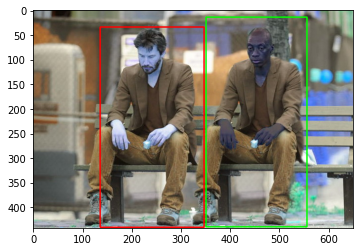

In [ ]:
import matplotlib.pyplot as plt
start_point, end_point = (detections[0,0],detections[0,1]),(detections[0,2],detections[0,3])
img2 = cv2.rectangle(img, start_point, end_point,(255,0,0),2)
start_point, end_point = (detections[1,0],detections[1,1]),(detections[1,2],detections[1,3])
img2 = cv2.rectangle(img2, start_point, end_point,(0,255,0),2)
# start_point, end_point = (detections[2,0],detections[2,1]),(detections[2,2],detections[2,3])
# img2 = cv2.rectangle(img2, start_point, end_point,(0,0,255),2)
plt.imshow(img2)

In [ ]:
detc_St = timer()
detections = detector.predict_single(img)
detc_Ft = timer()

print(detections)
print(detc_Ft - detc_St)

tensor([[102.4758,  62.3244, 339.0353, 424.4930,   0.9998,   0.9979,   0.0000],
        [335.0600,  67.5484, 560.8021, 419.8889,   0.9995,   0.9948,   0.0000]])
0.05455645600000025


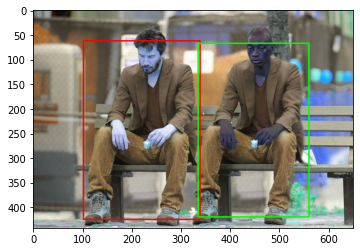

In [ ]:
# import matplotlib.pyplot as plt
start_point, end_point = (detections[0,0],detections[0,1]),(detections[0,2],detections[0,3])
img2 = cv2.rectangle(img, start_point, end_point,(255,0,0),2)
start_point, end_point = (detections[1,0],detections[1,1]),(detections[1,2],detections[1,3])
img2 = cv2.rectangle(img2, start_point, end_point,(0,255,0),2)
# start_point, end_point = (detections[2,0],detections[2,1]),(detections[2,2],detections[2,3])
# img2 = cv2.rectangle(img2, start_point, end_point,(0,0,255),2)
plt.imshow(img2)

In [ ]:
del detector

### Proper Data Acquisition

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!pip install mxnet-cu101

     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:11tcmalloc: large alloc 1147494400 bytes == 0x39c1c000 @  0x7fd6bcc51615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.4MB 22kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
!pip install --upgrade insightface

  Created wheel for insightface: filename=insightface-0.1.5-cp36-none-any.whl size=16766 sha256=9b704db9281d20b3852eba13d2c6384fe3be365d888fea8950b12b149ba1069c
  Stored in directory: /root/.cache/pip/wheels/11/b8/83/2bac12a833d66d58aa9705f5e7d94d2e9055f16f4698af0df7
Successfully built insightface


In [ ]:
import insightface

In [ ]:
fa_model = insightface.model_zoo.get_model('retinaface_r50_v1')

Model file is not found. Downloading.


100%|██████████| 107062/107062 [00:04<00:00, 24635.93KB/s]


In [ ]:
fa_model.prepare(ctx_id = 0, nms=0.4)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


In [ ]:
from multimodalDLforER.models.basic_HRnet import SimpleHRNet as HRnet

In [ ]:
cpw48_dir = '/content/drive/MyDrive/Tesis-p/checkpoints/hrnet_w48_384x288.pth'
cpw32_dir = '/content/drive/MyDrive/Tesis-p/checkpoints/hrnet_w32_384x288.pth' # lighter

In [ ]:
pose_model = HRnet(48, 17, cpw48_dir, multiperson=False, max_batch_size=2)

device: 'cuda' - 1 GPU(s) will be used


In [ ]:
directed_edges = [(1, 3), (3, 5), (2, 4), (4, 6),
				  (7, 9), (9, 11), (8, 10), (10, 12),
				  (13, 0), (13, 1), (13, 2), (13, 14),
				  (14, 8), (14, 7), (13, 13)]

def get_skeleton_data(keypoints):
	fail = 0
	for kp in keypoints:
		if kp[2] <=0.4:
			fail +=1
	if fail > 13:
		return None, None
	
	p17 = (keypoints[5] + keypoints[6]) / 2.0
	p18 = (keypoints[11] + keypoints[12]) / 2.0
	pose = []
	for i,kp in enumerate(keypoints):
		if i > 0 and i < 5:
			continue
		pose.append(kp)
	pose.append(p17)
	pose.append(p18)
	pose = np.asarray(pose)
	
	C, T, V, N = 3, 1, 15, 1 #chanels, frame, joints, persons
	data_np_joint = np.zeros((C, T, V, N))
	data_np_bone = np.zeros((C, T, V, N))
	
	data_np_joint[0, 0, :, 0] = pose[:,0]
	data_np_joint[1, 0, :, 0] = pose[:,1]
	data_np_joint[2, 0, :, 0] = pose[:,2]
	
	for v1,v2 in directed_edges:
		data_np_bone[:,:,v1,:] = data_np_joint[:,:,v1,:] - data_np_joint[:,:,v2,:]
	
	return data_np_joint, data_np_bone

In [ ]:
def extract_data(ori_img, bbox, pose_model, fa_model):
  if len(bbox) == 0:
    return None
  context = ori_img.copy()
  body = context[bbox[1]:bbox[3],bbox[0]:bbox[2]].copy()
  cn = body.shape

  pose = pose_model.predict(body)

  body = cv2.resize(body,(256,256))
  fbbox, _ = fa_model.detect(body,threshold=0.5, scale=1.0)
  if len(fbbox) != 0:
    fbbox = np.round(fbbox[0]).astype('int32')
    face = body[fbbox[1]:fbbox[3],fbbox[0]:fbbox[2]].copy()
    body[fbbox[1]:fbbox[3],fbbox[0]:fbbox[2]] = np.zeros(face.shape)
  else:
    face = None

  context[bbox[1]:bbox[3],bbox[0]:bbox[2]] = np.zeros(cn)
  joints, bones = get_skeleton_data(pose[0])
  
  return (context, body, face, joints, bones)

In [ ]:
def save_data(imagename, id, data, folder=''):
  name = imagename[:-4]
  nid = str(id).zfill(3)
  ctxfile = name +'_cntx_'+ nid +'.npy'
  bodfile = name +'_body_'+ nid +'.npy'
  facfile = name +'_face_'+ nid +'.npy'
  joifile = name +'_joit_'+ nid +'.npy'
  bonfile = name +'_bone_'+ nid +'.npy'
  ctxnp = cv2.resize(data[0], (224,224))
  np.save(join(folder, ctxfile), ctxnp)
  bodnp = cv2.resize(data[1], (224,224))
  np.save(join(folder, bodfile), bodnp)
  if data[2] is None or len(data[2])==0:
    facnp = np.zeros(16)
    np.save(join(folder, facfile), facnp)
  else:
    facnp = cv2.resize(data[2], (48,48))
    np.save(join(folder, facfile), facnp)
  if data[3] is None or len(data[3])==0:
    joinp = np.zeros(16)
    bonnp = np.zeros(16)
    np.save(join(folder, joifile), joinp)
    np.save(join(folder, bonfile), bonnp)
  else:
    joinp = data[3]
    bonnp = data[4]
    np.save(join(folder, joifile), joinp)
    np.save(join(folder, bonfile), bonnp)
  
  return (ctxnp, bodnp, facnp, joinp, bonnp)

In [ ]:
all_data = []
ori_img = cv2.imread("sb-2p.jpg")

In [ ]:
img_St = timer()
for i,(x1, y1, x2, y2, conf, cls_conf, cls_pred) in enumerate(detections):
  x1 = int(round(x1.item()))
  x2 = int(round(x2.item()))
  y1 = int(round(y1.item()))
  y2 = int(round(y2.item()))
  bbox = [x1, y1, x2, y2]
  pers_St = timer()
  data = extract_data(ori_img, bbox, pose_model, fa_model)
  pers_Ft = timer()
  print('person {}: {}'.format(i,pers_Ft-pers_St))
  data2 = save_data(image, i, data)
  all_data.append(data2)
img_Ft = timer()
print('whole image:', img_Ft-img_St)

person 0: 0.08889679100002468
person 1: 0.08192289299995537
whole image: 0.17743339800017566


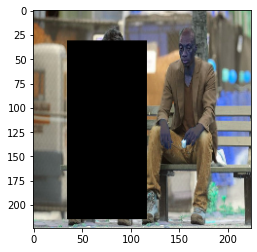

In [ ]:
plt.imshow(all_data[0][0])

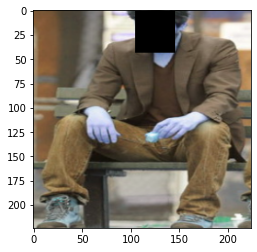

In [ ]:
plt.imshow(all_data[0][1])

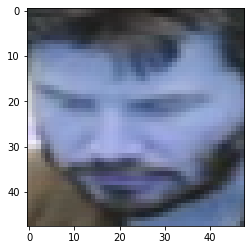

In [ ]:
plt.imshow(all_data[0][2])

In [ ]:
del pose_model
del fa_model

### Multi-modal Prediction

In [ ]:
def transformTensor(data):
  tdata = dict()
  tdata['context'] = torch.from_numpy(data[0].transpose((2, 0, 1))).unsqueeze_(0).float().to(device)
  tdata['body'] = torch.from_numpy(data[1].transpose((2, 0, 1))).unsqueeze_(0).float().to(device)
  try:
    tdata['face'] = torch.from_numpy(data[2].transpose((2, 0, 1))).unsqueeze_(0).float().to(device)
    tdata['joint'] = torch.from_numpy(data[3]).unsqueeze_(0).float().to(device)
    tdata['bone'] = torch.from_numpy(data[4]).unsqueeze_(0).float().to(device)
  except:
    tdata['face'] = torch.from_numpy(data[2]).unsqueeze_(0).float().to(device)
    tdata['joint'] = torch.from_numpy(data[3]).unsqueeze_(0).float().to(device)
    tdata['bone'] = torch.from_numpy(data[4]).unsqueeze_(0).float().to(device)
  return tdata

In [ ]:
from multimodalDLforER.models.context_net import resnet18
from multimodalDLforER.models.face_net import ShortVGG as VGG
from multimodalDLforER.models.skeleton_net import Model as DGCNN

from multimodalDLforER.models.fusion_model import MergeClass

In [ ]:
loadeddict = torch.load("/content/drive/MyDrive/Tesis-p/checkpoints/unimodals/bodyabn_last.pth")

In [ ]:
body_model = resnet18(num_classes=8)
body_model = body_model.to(device)
body_model.load_state_dict(loadeddict['model_state_dict'])

<All keys matched successfully>

In [ ]:
loadeddict = torch.load("/content/drive/MyDrive/Tesis-p/checkpoints/unimodals/contextabn_best.pth")

In [ ]:
context_model = resnet18(num_classes=8)
context_model = context_model.to(device)
context_model.load_state_dict(loadeddict['model_state_dict'])

<All keys matched successfully>

In [ ]:
loadeddict = torch.load("/content/drive/MyDrive/Tesis-p/checkpoints/unimodals/facevgg_best.pth")

In [ ]:
face_model = VGG('VGG19',8).to(device)
face_model.load_state_dict(loadeddict['model_state_dict'])

<All keys matched successfully>

In [ ]:
loadeddict = torch.load("/content/drive/MyDrive/Tesis-p/checkpoints/unimodals/posedgcnn_ws_last.pth")

In [ ]:
pose_model = DGCNN().to(device)
pose_model.load_state_dict(loadeddict['model_state_dict'])

<All keys matched successfully>

In [ ]:
del loadeddict

uni_models = {'body':body_model.eval(),
              'context':context_model.eval(),
              'face':face_model.eval(),
              'pose':pose_model.eval()}

In [ ]:
Merge_5_configures = {
	'type':	5,
	'parameters': {
		'num_classes': 8,
		'input_sizes': 4,
		'final_input_sizes': 4,
		'embrace1_param': {
			'input_size_list': [512, 512, 512, 512, ],
			'embracement_size': 512,
			'docker_arch': [[1024, 'D', 512], [1024, 'D', 512], [1024, 'D', 512], [1024, 'D', 512],],
			'device': torch.device('cuda'),
		},
		'embrace2_param': {
			'input_size_list': [8, 8, 8, 8, ],
			'embracement_size': 32,
			'docker_arch': [[64, 'D', 32], [64, 'D', 32], [64, 'D', 32], [64, 'D', 32],],
			'device': torch.device('cuda'),
		},
		'embrace3_param': {
			'input_size_list': [128, 32, 8, 32,],
			'embracement_size': 64,
			'docker_arch': [[64], [64], [64], [64],],
			'device': torch.device('cuda'),
		},
		'wsum_confg': {
      'number_modals': 4,
			'outchannels': 1,
			'probabilities': None,
			'trainable': False,
			'mode': 'tensor', # 'convs', #
			'device': torch.device('cuda'),
    },
		'device': torch.device('cuda'),
		'trainable_probs': False,
		'useffinal': True,
		'use_ws': True,
		'use_ll': [True, False, True],
		'll_configs': [
			{'config': [128] ,
			'embrace_size': 512,},
			{},
			{'config': [8] ,
			'embrace_size': 64,}
		]}
}

In [ ]:
dicti = torch.load("/content/drive/MyDrive/Tesis-p/checkpoints/multimodal/all_mergenew_last.pth")

In [ ]:
MergerModel = MergeClass(uni_models, Merge_5_configures, device)

MergerModel.load_state_dict(dicti['model_state_dict'])
MergerModel.eval()

In [ ]:
for i, dt in enumerate(all_data):
  pred_St = time.time()
  MergerModel.forward(transformTensor(dt))
  pred_Ft = time.time()
  print(pred_Ft - pred_St)

0.04017138481140137
0.029730558395385742


In [ ]:
del dicti

del body_model
del context_model
del face_model
del pose_model

del MergerModel